# NLP


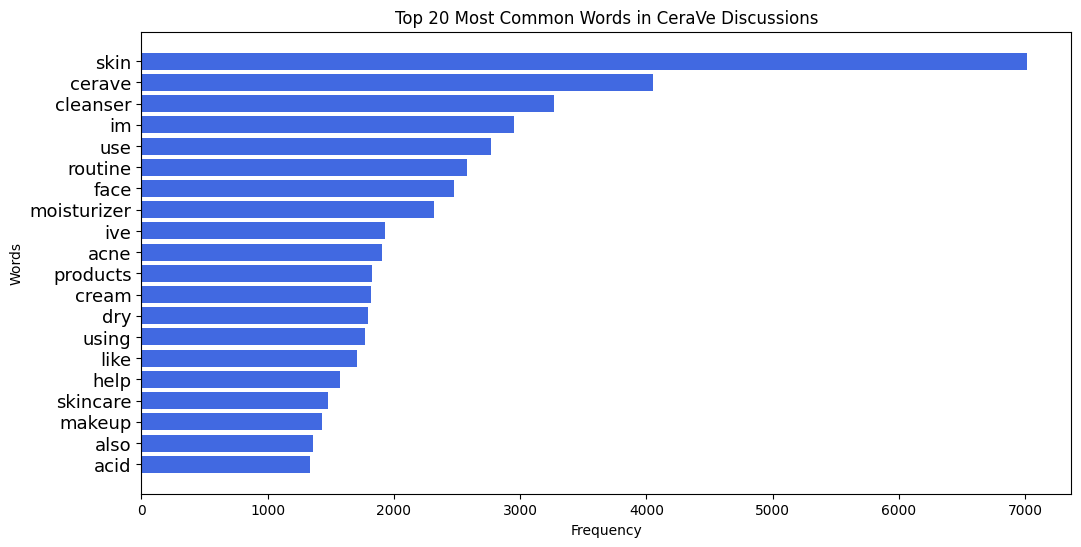

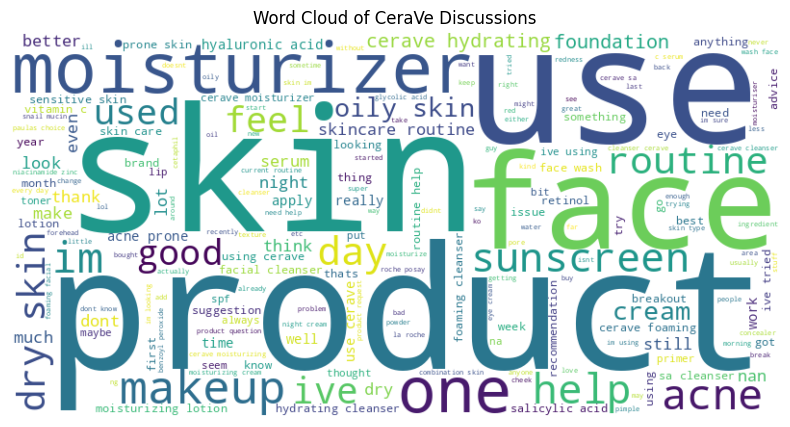

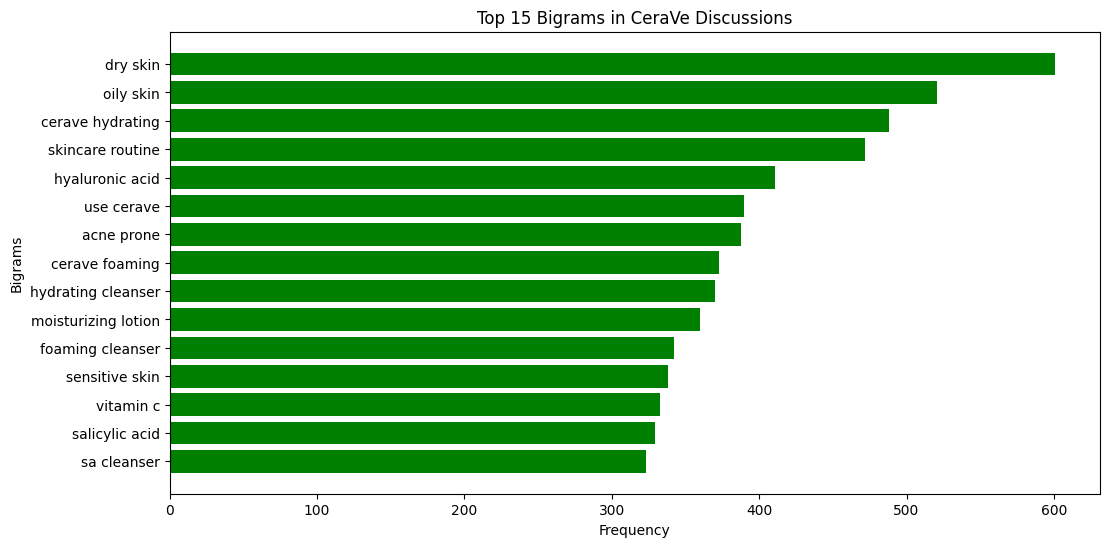

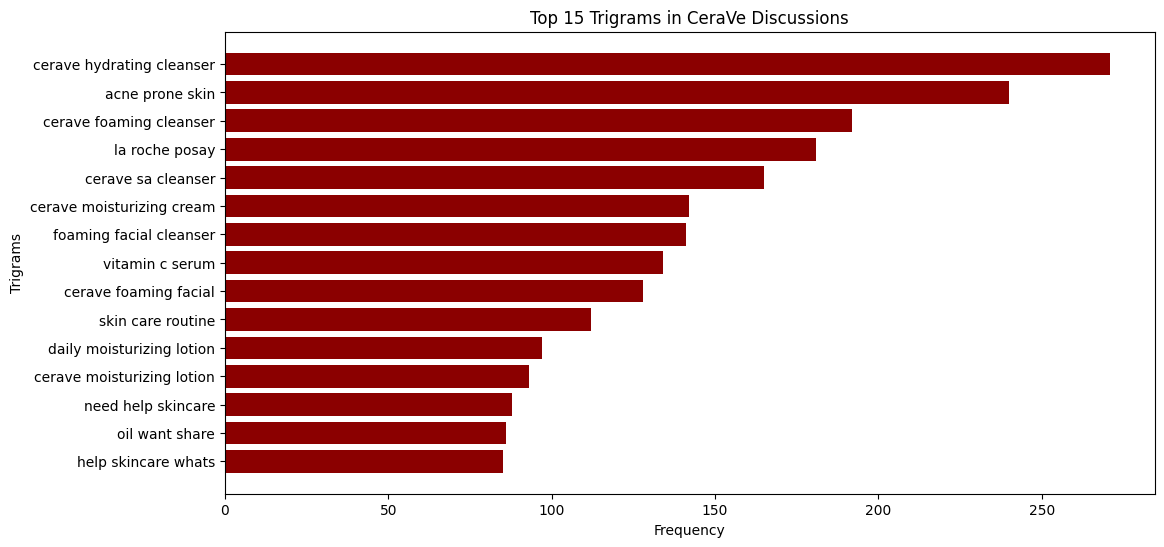

<ipython-input-1-cc69844f107b>:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_brand_mentions["Brand"], x=df_brand_mentions["Frequency"], palette="Blues_r")


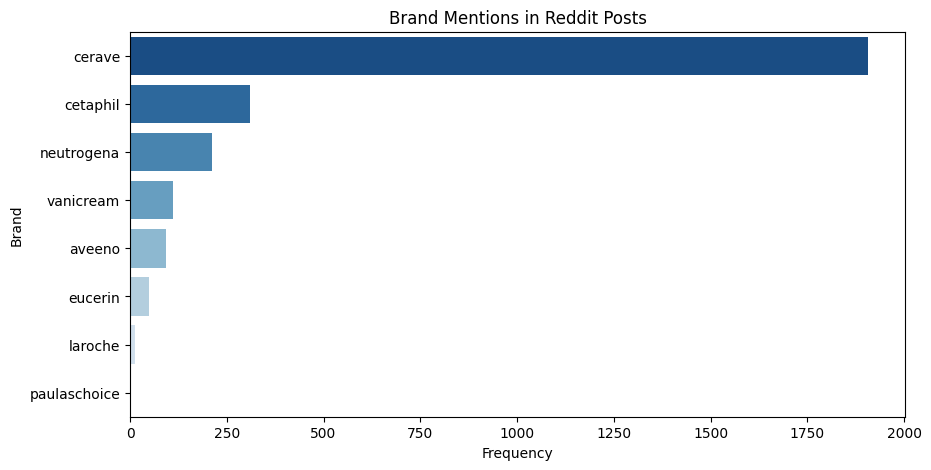

<ipython-input-1-cc69844f107b>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Oranges_r")


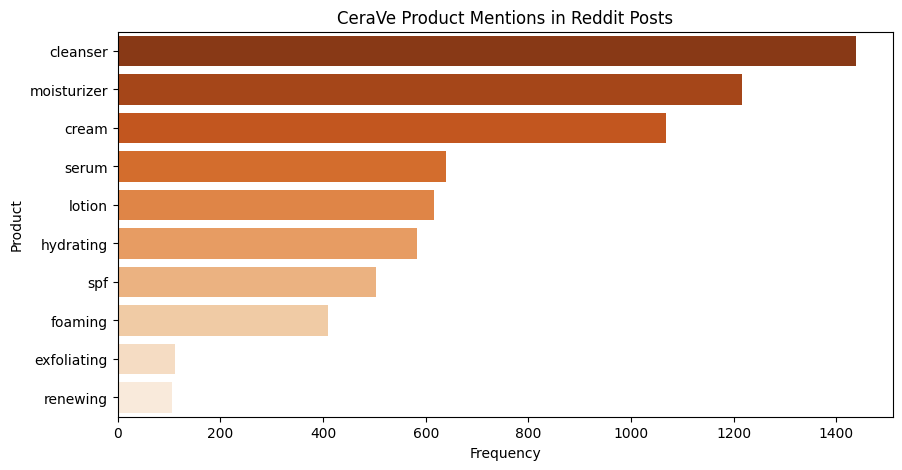

In [ ]:
import re
import ast
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
"""from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download("punkt")
nltk.download("stopwords")
"""
# Load dataset
file_path = "data/CeraVe_reddit_filtered_with_popularity_numeric.csv"
df = pd.read_csv(file_path)

# Ensure 'tokens' column is a proper list
def ensure_list_format(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) and value.startswith("[") else value
    except:
        return []  # Return an empty list if conversion fails

df["tokens"] = df["tokens"].apply(ensure_list_format)

"""# Ensure 'tokens' column has valid lists
if not isinstance(df["tokens"].iloc[0], list):
    print("Warning: Tokens column is not in the correct list format. Retokenizing...")

    # Define text cleaning and tokenization function
    def clean_text(text):
        text = str(text).lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize words
        tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
        return tokens

    # Apply cleaning and tokenization
    df["tokens"] = df["text"].apply(clean_text)
"""
# Flatten the list of all words
all_words = [word for tokens in df['tokens'] if isinstance(tokens, list) for word in tokens]

# Get most common words
word_freq = Counter(all_words).most_common(20)

# Convert to dataframe for visualization
word_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

#  Word Frequency
plt.figure(figsize=(12,6))
plt.barh(word_df['Word'], word_df['Frequency'], color='royalblue')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.yticks(fontsize=13)
plt.title("Top 20 Most Common Words in CeraVe Discussions")
plt.gca().invert_yaxis()
plt.show()

#  Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of CeraVe Discussions")
plt.show()

#  Bigrams & Trigrams
bigram_freq = Counter(ngrams(all_words, 2)).most_common(15)
trigram_freq = Counter(ngrams(all_words, 3)).most_common(15)

# Convert bigrams to readable format
bigram_df = pd.DataFrame(bigram_freq, columns=['Bigram', 'Frequency'])
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))

# Convert trigrams to readable format
trigram_df = pd.DataFrame(trigram_freq, columns=['Trigram', 'Frequency'])
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))

#  Visualizing Bigrams
plt.figure(figsize=(12,6))
plt.barh(bigram_df['Bigram'], bigram_df['Frequency'], color='green')
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.title("Top 15 Bigrams in CeraVe Discussions")
plt.gca().invert_yaxis()
plt.show()

# Visualizing Trigrams
plt.figure(figsize=(12,6))
plt.barh(trigram_df['Trigram'], trigram_df['Frequency'], color='darkred')
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.title("Top 15 Trigrams in CeraVe Discussions")
plt.gca().invert_yaxis()
plt.show()

### **🛒 Brand Comparisons**
# Define competing brands
brands = ["cerave", "cetaphil", "neutrogena", "laroche", "paulaschoice", "aveeno", "eucerin", "vanicream"]

# Count mentions of each brand
df["brand_mentions"] = df["text"].apply(lambda x: [brand for brand in brands if brand in str(x).lower()])
brand_counts = Counter([brand for sublist in df["brand_mentions"] for brand in sublist])

# Convert to DataFrame and Plot
df_brand_mentions = pd.DataFrame(brand_counts.items(), columns=["Brand", "Frequency"]).sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(y=df_brand_mentions["Brand"], x=df_brand_mentions["Frequency"], palette="Blues_r")
plt.title("Brand Mentions in Reddit Posts")
plt.xlabel("Frequency")
plt.ylabel("Brand")
plt.show()

### **🔍 Most Common Product Mentions**
# Define key CeraVe product words
cerave_products = ["cleanser", "moisturizer", "hydrating", "foaming", "lotion", "serum", "spf", "cream", "exfoliating", "renewing"]

# Count mentions of each product
df["product_mentions"] = df["text"].apply(lambda x: [product for product in cerave_products if product in str(x).lower()])
product_counts = Counter([product for sublist in df["product_mentions"] for product in sublist])

# Convert to DataFrame and Plot
df_product_mentions = pd.DataFrame(product_counts.items(), columns=["Product", "Frequency"]).sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Oranges_r")
plt.title("CeraVe Product Mentions in Reddit Posts")
plt.xlabel("Frequency")
plt.ylabel("Product")
plt.show()


# Improved LDA  

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import pickle
import re

#  1. Load and clean dataset
df = pd.read_csv("data/CeraVe_reddit_filtered_with_popularity_numeric.csv")
df.dropna(subset=["text"], inplace=True)
df["text"] = df["text"].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))  # Remove URLs

#  2. CountVectorizer setup (better for LDA than TF-IDF)
vectorizer = CountVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2),
    min_df=10,               # Ignore rare words
    max_df=0.9,              # Remove extremely common words
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Filter out short/meaningless tokens
)

tf_matrix = vectorizer.fit_transform(df["text"])

#  3. Train LDA model
best_n_topics = 10
lda_model = LatentDirichletAllocation(
    n_components=best_n_topics,
    learning_decay=0.5,
    doc_topic_prior=0.3,  # Higher alpha to encourage balanced topic mix
    max_iter=200,
    random_state=42
)
lda_model.fit(tf_matrix)

#  4. Display top words for each topic
def show_lda_topics(model, vectorizer, top_n=10):
    words = np.array(vectorizer.get_feature_names_out())
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = words[topic.argsort()[:-top_n - 1:-1]]
        topics[topic_idx] = ", ".join(topic_words)
        print(f" Topic {topic_idx}: {', '.join(topic_words)}")
    return topics

topics = show_lda_topics(lda_model, vectorizer, top_n=15)

#  5. Topic labeling function (rule-based keyword matching)
def assign_topic_labels(topic_keywords):
    topic_keywords = topic_keywords.lower()
    topic_scores = {
        "Skincare Tips & Advice": sum(word in topic_keywords for word in [
            "tips", "tricks", "advice", "help", "share", "need help", "right", "difference", "emulsion", "routine advice"
        ]),
        "Ingredients & Treatments": sum(word in topic_keywords for word in [
            "niacinamide", "hyaluronic", "retinol", "aha", "bha", "vitamin", "ceramide", "acid", "serum", "treatment"
        ]),
        "Makeup & Cosmetic Products": sum(word in topic_keywords for word in [
            "foundation", "concealer", "primer", "powder", "blush", "mascara", "eyeshadow", "lipstick", "makeup", "beauty"
        ]),
        "Product Recommendations & Shopping": sum(word in topic_keywords for word in [
            "buy", "price", "recommend", "favorite", "best", "worth", "white cast", "fake", "authentic", "reviews", "let know", "product advice"
        ]),
        "Skin Type & Sensitivity": sum(word in topic_keywords for word in [
            "dry", "oily", "sensitive", "eczema", "rosacea", "acne-prone", "prone", "skin type", "redness", "flaky", "breakout", "itchy"
        ]),
        "Daily Skincare Routine": sum(word in topic_keywords for word in [
            "morning", "night", "day", "wash", "cleanser", "routine", "face wash", "sunscreen", "currently using", "everyday"
        ]),
    }

    best_topic = max(topic_scores, key=topic_scores.get)
    if topic_scores[best_topic] <= 0:
        return "Other"
    return best_topic

#  6. Assign dominant topic to each document
topic_distributions = lda_model.transform(tf_matrix)
df["Dominant Topic"] = topic_distributions.argmax(axis=1)
df["Topic Label"] = df["Dominant Topic"].apply(lambda x: assign_topic_labels(topics[x]))

#  7. Print Topic Distributions
topic_counts = df["Dominant Topic"].value_counts()
print("\n LDA Topic Distribution:")
print(topic_counts)

topic_label_counts = df["Topic Label"].value_counts()
print("\n Topic Label Distribution:")
print(topic_label_counts)

#  8. Save results
df.to_csv("CeraVe_LDA_Dominant_Topics.csv", index=False)

df_topics = pd.DataFrame(list(topics.items()), columns=["Topic Number", "Keywords"])
df_topics["Topic Label"] = df_topics["Keywords"].apply(assign_topic_labels)
df_topics.to_csv("data/CeraVe_LDA_Topics_Labeled.csv", index=False)

print("\n LDA results have been saved successfully! ")


🔹 Topic 0: oil, cream, water, skin, cosrx, toner, cleansing, serum, snail, cleanser, gel, products, mucin, snail mucin, beauty
🔹 Topic 1: cerave, moisturizer, moisturizing, lotion, facial, face, cleanser, skin, cream, spf, routine, gel, sunscreen, moisturizing lotion, roche
🔹 Topic 2: acid, ordinary, serum, cleanser, routine, cerave, niacinamide, hyaluronic, retinol, hyaluronic acid, vitamin, toner, skin, cream, moisturizer
🔹 Topic 3: skincare, difference, need help, share, help, place, tips, need, want, oil, right, emulsion, toner, tricks, tips tricks
🔹 Topic 4: ako, yung, lang, pero, ang, kasi, products, bought, naman, nag, skin, talaga, din, sunscreen, hindi
🔹 Topic 5: makeup, foundation, primer, powder, concealer, elf, use, setting, spray, look, blush, wear, beauty, mascara, products
🔹 Topic 6: skin, cleanser, acne, using, cerave, oily, just, used, started, prone, months, new, like, really, sensitive
🔹 Topic 7: skin, dry, like, face, just, don, really, feel, tried, use, good, cream

# Sentiment Analysis Trends

In [ ]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer


# Load cleaned dataset
df = pd.read_csv("data/CeraVe_reddit_filtered_with_popularity_numeric.csv")

# Remove NaN values from the text column
df.dropna(subset=["text"], inplace=True)

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment score
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis
df['sentiment_score'] = df['text'].astype(str).apply(get_sentiment)

# Categorize sentiment based on score
def categorize_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Check if sentiment category is now populated
print("Sentiment Category Distribution:\n", df["sentiment_category"].value_counts())

# Save updated data
df.to_csv("data/CeraVe_reddit_with_sentiment.csv", index=False)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Category Distribution:
 sentiment_category
Positive    2425
Negative     431
Neutral      155
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

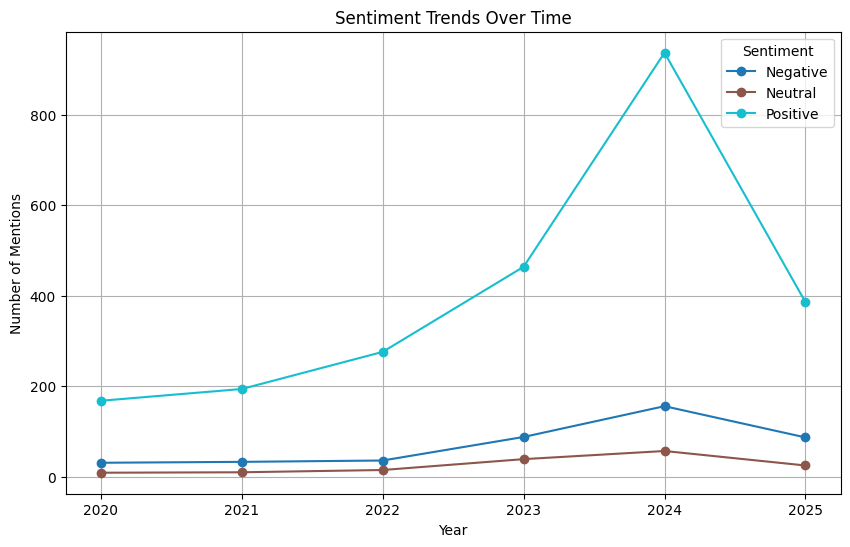

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer

# Load dataset
file_path = "data/CeraVe_reddit_with_sentiment.csv"  # Ensure this file is uploaded
df = pd.read_csv(file_path)

# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the 'text' column
df['sentiment_score'] = df['text'].astype(str).apply(lambda text: sia.polarity_scores(text)['compound'])

# Categorize sentiment
df['sentiment_category'] = df['sentiment_score'].apply(
    lambda x: "Positive" if x >= 0.05 else "Negative" if x <= -0.05 else "Neutral"
)

# Extract year for trend analysis
df['year'] = df['timestamp'].dt.year

# Count sentiment per year
sentiment_trends = df.groupby(['year', 'sentiment_category']).size().unstack().fillna(0)

# Plot sentiment trend over the years
plt.figure(figsize=(10, 6))
sentiment_trends.plot(kind='line', marker='o', figsize=(10, 6), colormap='tab10')
plt.title("Sentiment Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()


# Engagement vs. Sentiment Analysis

<>:12: DeprecationWarning: invalid escape sequence '\d'
<>:12: DeprecationWarning: invalid escape sequence '\d'
<ipython-input-12-7197902a9669>:12: DeprecationWarning: invalid escape sequence '\d'
  df['comments'] = df['comments'].str.extract('(\d+)')  # Extract only numeric digits


Fixed Data Types:
title                   object
text                    object
upvotes                  int64
comments               float64
timestamp               object
url                     object
subreddit               object
keyword                 object
full_text               object
tokens                  object
log_upvotes            float64
popularity_category      int64
sentiment_score        float64
sentiment_category      object
dtype: object

Minimum and Maximum comments: 1.0 44094365696153.0


<ipython-input-12-7197902a9669>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment_category", y="upvotes", data=df, palette=palette)


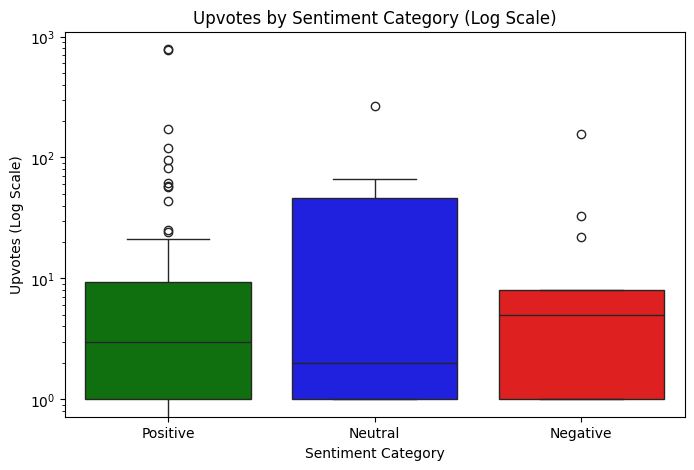

<ipython-input-12-7197902a9669>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment_category", y="comments", data=df, palette=palette)


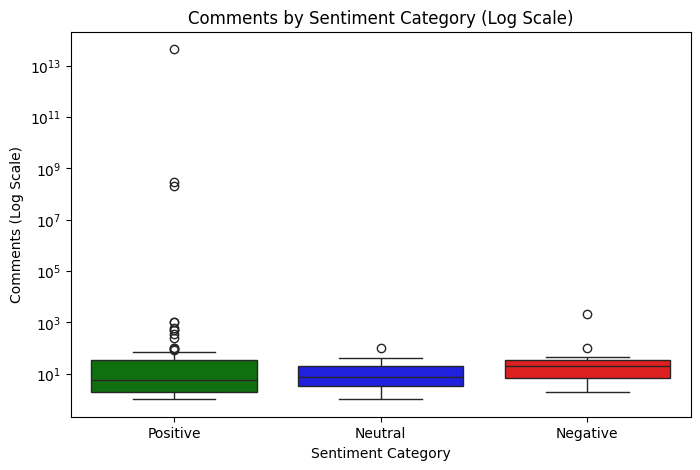

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("data/CeraVe_reddit_with_sentiment.csv")

# Convert 'upvotes' to numeric
df['upvotes'] = pd.to_numeric(df['upvotes'], errors='coerce')

# **Fix 'comments' column: Extract only numeric values**
df['comments'] = df['comments'].str.extract('(\d+)')  # Extract only numeric digits
df['comments'] = pd.to_numeric(df['comments'], errors='coerce')  # Convert to integer

# **Drop rows with NaN values in required columns**
df = df.dropna(subset=['upvotes', 'comments', 'sentiment_category'])

# **Check data again**
print("Fixed Data Types:")
print(df.dtypes)
print("\nMinimum and Maximum comments:", df["comments"].min(), df["comments"].max())

# **Re-run Boxplots**
palette = {"Positive": "green", "Neutral": "blue", "Negative": "red"}

# **Boxplot for Upvotes by Sentiment**
plt.figure(figsize=(8,5))
sns.boxplot(x="sentiment_category", y="upvotes", data=df, palette=palette)
plt.yscale("log")  # Log scale for better visualization
plt.title("Upvotes by Sentiment Category (Log Scale)")
plt.xlabel("Sentiment Category")
plt.ylabel("Upvotes (Log Scale)")
plt.show()

# **Boxplot for Comments by Sentiment**
plt.figure(figsize=(8,5))
sns.boxplot(x="sentiment_category", y="comments", data=df, palette=palette)
plt.yscale("log")  # Log scale for better visualization
plt.title("Comments by Sentiment Category (Log Scale)")
plt.xlabel("Sentiment Category")
plt.ylabel("Comments (Log Scale)")
plt.show()


<ipython-input-117-7e83e54f3823>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=topic_sentiment_top3.index, y=topic_sentiment_top3.values, palette="coolwarm", ax=ax1)


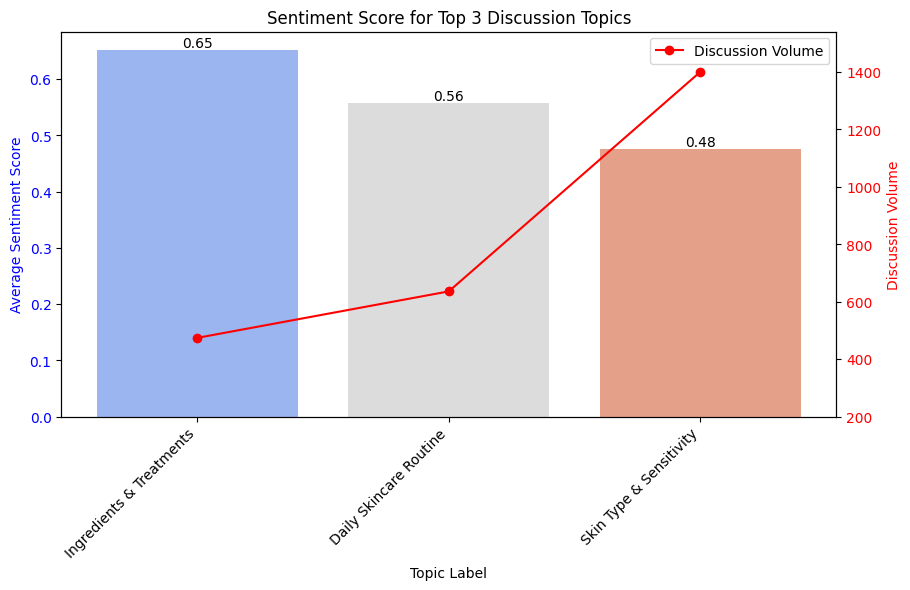

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load LDA topic data
df_lda = pd.read_csv("data/CeraVe_LDA_Dominant_Topics.csv")
df_lda = df_lda.drop_duplicates(subset=["text"])

# Load sentiment scores
df_sentiment = pd.read_csv("data/CeraVe_reddit_with_sentiment.csv")
df_sentiment = df_sentiment.merge(df_lda[["text", "Dominant Topic"]], on="text", how="left")

# Load LDA topic labels
df_topics = pd.read_csv("data/CeraVe_LDA_Topics_Labeled.csv")

# Merge topic labels with sentiment scores
df = df_sentiment.merge(df_topics, left_on="Dominant Topic", right_on="Topic Number", how="left")

# Compute average sentiment for each topic
topic_sentiment = df.groupby("Topic Label")["sentiment_score"].mean()

# Compute discussion volume per topic
topic_counts = df["Topic Label"].value_counts()

# Ensure all topics are included
topic_counts = topic_counts.reindex(topic_sentiment.index, fill_value=0)

top_3_topics = topic_counts.nlargest(3)

topic_sentiment_top3 = topic_sentiment.loc[top_3_topics.index].sort_values(ascending=False)
top_3_topics_sorted = top_3_topics.loc[topic_sentiment_top3.index]

fig, ax1 = plt.subplots(figsize=(10, 5))

# sentiment
ax1 = sns.barplot(x=topic_sentiment_top3.index, y=topic_sentiment_top3.values, palette="coolwarm", ax=ax1)
ax1.set_xlabel("Topic Label")
ax1.set_ylabel("Average Sentiment Score", color="blue")
ax1.set_title("Sentiment Score for Top 3 Discussion Topics")
ax1.tick_params(axis='y', labelcolor="blue")
plt.xticks(rotation=45, ha="right")

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# ax2
ax2 = ax1.twinx()
ax2.plot(topic_sentiment_top3.index, top_3_topics_sorted,
         marker='o', linestyle='-', color='red', label="Discussion Volume")
ax2.set_ylabel("Discussion Volume", color='red')
ax2.tick_params(axis='y', labelcolor="red")
ax2.legend(loc="upper right")

# 200~
ax2.set_ylim(200, max(top_3_topics_sorted) * 1.1)

plt.show()

df.to_csv("data/CeraVe_LDA_Topics_with_Sentiment.csv", index=False)

In [ ]:
"""print("count :")
print(df["Topic Label"].value_counts())

print("\n Average entiment socre by Topic：")
print(df.groupby("Topic Label")["sentiment_score"].mean())

print(df["Dominant Topic"].value_counts())"""


討論量統計：
Topic Label
Skin Type & Sensitivity               1401
Daily Skincare Routine                 636
Ingredients & Treatments               474
Makeup & Cosmetic Products             244
Skincare Tips & Advice                  86
Product Recommendations & Shopping      42
Name: count, dtype: int64

每個 Topic 的平均情緒分數：
Topic Label
Daily Skincare Routine                0.557828
Ingredients & Treatments              0.651818
Makeup & Cosmetic Products            0.574803
Product Recommendations & Shopping    0.464902
Skin Type & Sensitivity               0.475885
Skincare Tips & Advice                0.665965
Name: sentiment_score, dtype: float64
Dominant Topic
7.0    712
6.0    689
2.0    369
8.0    295
1.0    257
5.0    244
0.0    105
3.0     86
4.0     84
9.0     42
Name: count, dtype: int64


# Pros and Cons


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unique sentiment categories: ['Negative' 'Positive' 'Neutral']
Number of negative reviews in selected topics: 272


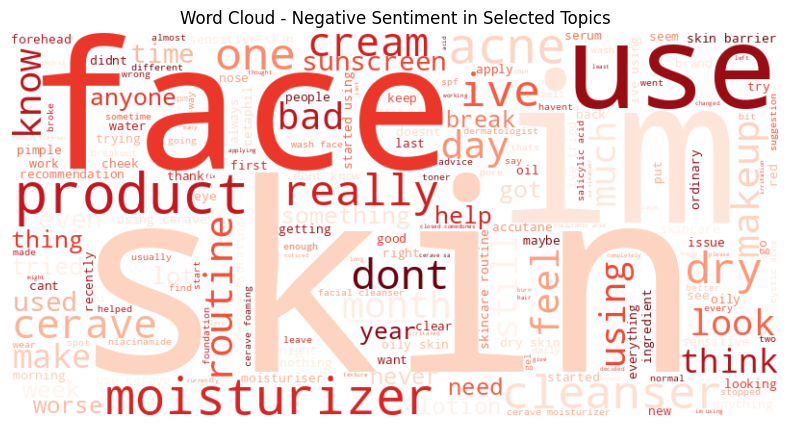

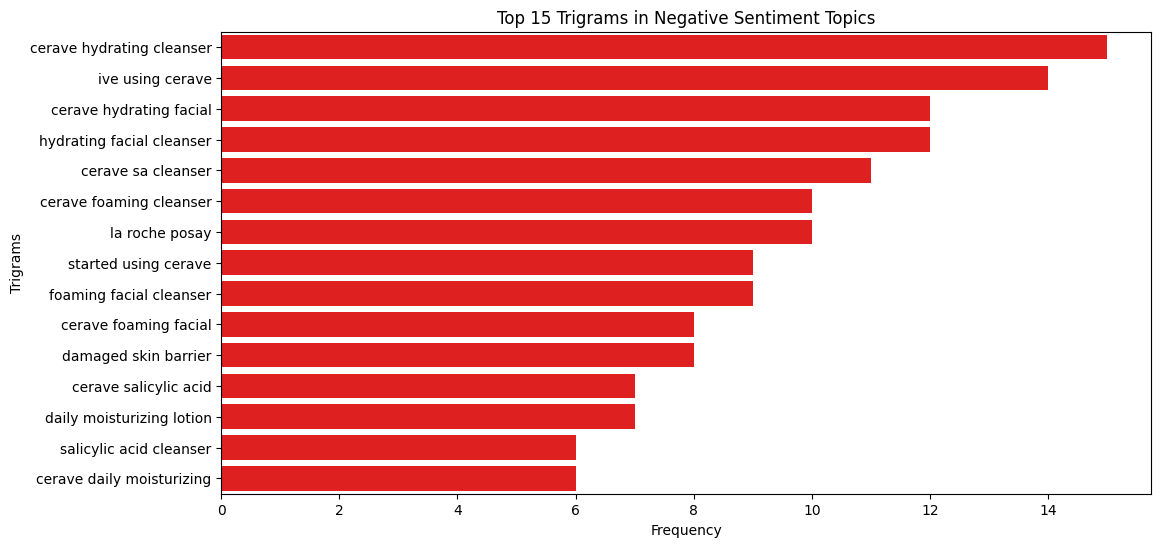

<ipython-input-119-b441011c504f>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews["product_mentions"] = negative_reviews["text"].apply(
<ipython-input-119-b441011c504f>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Reds_r")


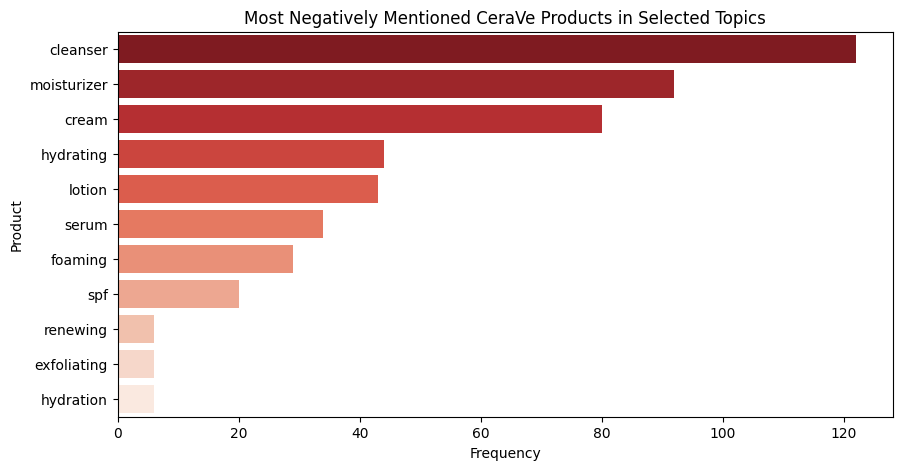

In [ ]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams

# Download required NLTK data
nltk.download("punkt")
nltk.download("stopwords")

# Load dataset
file_path = "data/CeraVe_LDA_Topics_with_Sentiment.csv"
df = pd.read_csv(file_path)

# Ensure 'text' is a string before applying processing
df["text"] = df["text"].astype(str)

# Check sentiment categories
print("Unique sentiment categories:", df["sentiment_category"].unique())

# Strip whitespace from topic labels
df["Topic Label"] = df["Topic Label"].str.strip()

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    return tokens

# Apply cleaning function
df['tokens'] = df['text'].apply(clean_text)

# Filter for selected topics with negative sentiment
target_topics = ["Skin Type & Sensitivity"]
negative_reviews = df[(df['sentiment_category'] == "Negative") & (df['Topic Label'].isin(target_topics))]

print(f"Number of negative reviews in selected topics: {negative_reviews.shape[0]}")

if negative_reviews.empty:
    print("No negative reviews found for the selected topic. Skipping Word Cloud and Trigram Analysis.")
else:
    # Flatten word lists for trigrams
    negative_words = [word for tokens in negative_reviews['tokens'] for word in tokens]

    # Generate trigrams
    negative_trigrams = list(ngrams(negative_words, 3))

    # Find most common trigrams
    negative_trigram_freq = Counter(negative_trigrams).most_common(15)

    # Convert to DataFrame
    df_negative_trigrams = pd.DataFrame(negative_trigram_freq, columns=['Trigram', 'Frequency'])

    # Convert trigrams from tuples to readable text
    df_negative_trigrams['Trigram'] = df_negative_trigrams['Trigram'].apply(lambda x: ' '.join(x))

    # Create word cloud for negative topic posts
    if negative_words:
        negative_text = " ".join(negative_words)
        wordcloud_negative = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_text)

        # Display Word Cloud
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud_negative, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud - Negative Sentiment in Selected Topics")
        plt.show()
    else:
        print("No words found for Word Cloud generation.")

    # Plot Top 15 Trigrams for Negative Reviews
    plt.figure(figsize=(12,6))
    sns.barplot(y=df_negative_trigrams["Trigram"], x=df_negative_trigrams["Frequency"], color="red")
    plt.title("Top 15 Trigrams in Negative Sentiment Topics")
    plt.xlabel("Frequency")
    plt.ylabel("Trigrams")
    plt.show()

    # Most Common Negatively Reviewed CeraVe Products
    cerave_products = ["cleanser", "moisturizer", "hydrating", "foaming", "lotion",
                       "serum", "spf", "cream", "exfoliating", "renewing", "hydration"]

    # Count mentions of each product in negative reviews
    negative_reviews["product_mentions"] = negative_reviews["text"].apply(
        lambda x: [product for product in cerave_products if product in str(x).lower()]
    )
    product_counts = Counter([product for sublist in negative_reviews["product_mentions"] for product in sublist])

    # Convert to DataFrame and Plot
    df_product_mentions = pd.DataFrame(product_counts.items(), columns=["Product", "Frequency"]).sort_values(by="Frequency", ascending=False)

    if not df_product_mentions.empty:
        plt.figure(figsize=(10,5))
        sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Reds_r")
        plt.title("Most Negatively Mentioned CeraVe Products in Selected Topics")
        plt.xlabel("Frequency")
        plt.ylabel("Product")
        plt.show()
    else:
        print("No negative product mentions found.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


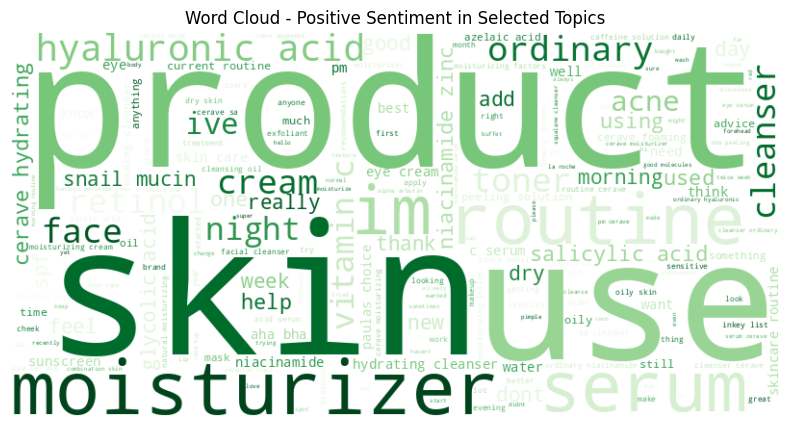

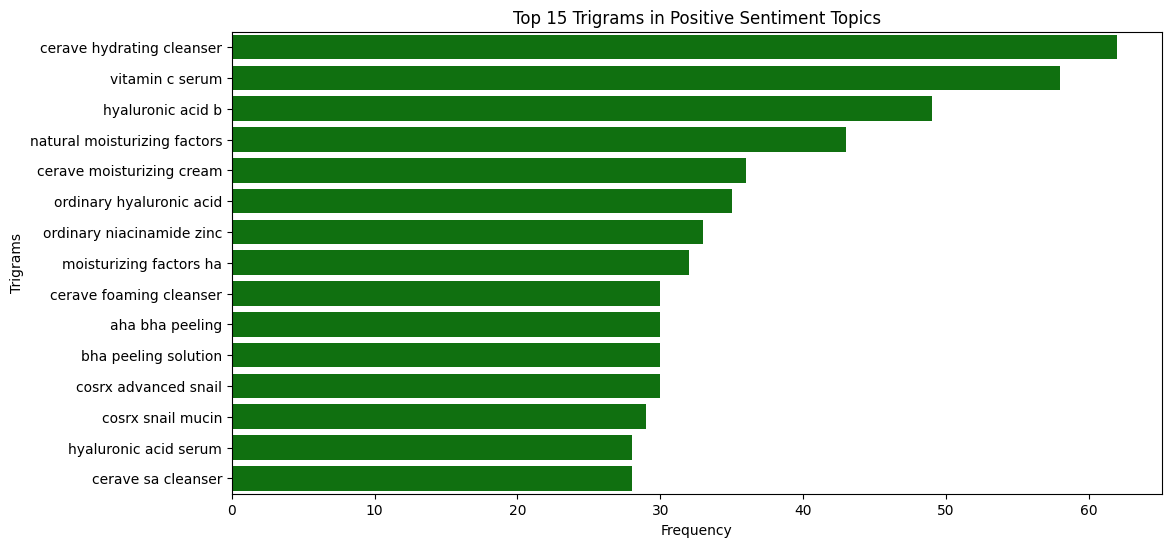

<ipython-input-120-e1a410b2a058>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews["product_mentions"] = positive_reviews["text"].apply(
<ipython-input-120-e1a410b2a058>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Greens_r")


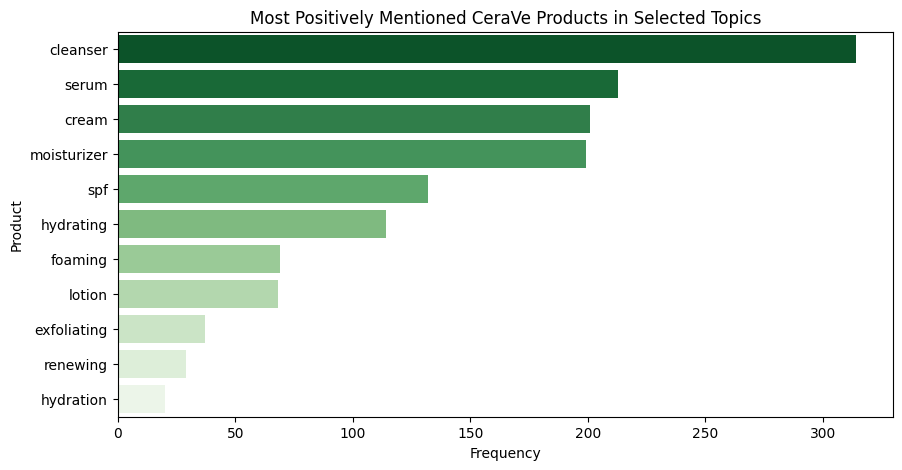

In [ ]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams

# Download required NLTK data
nltk.download("punkt")
nltk.download("stopwords")

# Load dataset
file_path = "data/CeraVe_LDA_Topics_with_Sentiment.csv"
df = pd.read_csv(file_path)

# Ensure 'text' is a string before applying processing
df["text"] = df["text"].astype(str)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return tokens

# Apply cleaning function
df['tokens'] = df['text'].apply(clean_text)

# Filter for topics with high negative sentiment
target_topics = ["Ingredients & Treatments"]
positive_reviews = df[(df['sentiment_category'] == "Positive") & (df['Topic Label'].isin(target_topics))]

# Flatten word lists for trigrams
positive_words = [word for tokens in positive_reviews['tokens'] for word in tokens]

# Generate trigrams
positive_trigrams = list(ngrams(positive_words, 3))

# Find most common trigrams
positive_trigram_freq = Counter(positive_trigrams).most_common(15)

# Convert to DataFrame
df_positive_trigrams = pd.DataFrame(positive_trigram_freq, columns=['Trigram', 'Frequency'])

# Convert trigrams from tuples to readable text
df_positive_trigrams['Trigram'] = df_positive_trigrams['Trigram'].apply(lambda x: ' '.join(x))

# Create word cloud for negative topic posts
positive_text = " ".join(positive_words)
wordcloud_positive = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_text)

# Display Word Cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment in Selected Topics")
plt.show()

# Plot Top 15 Trigrams for Negative Reviews
plt.figure(figsize=(12,6))
sns.barplot(y=df_positive_trigrams["Trigram"], x=df_positive_trigrams["Frequency"], color="green")
plt.title("Top 15 Trigrams in Positive Sentiment Topics")
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.show()

### **Most Common Negatively Reviewed CeraVe Products**
# Define key CeraVe product words
cerave_products = ["cleanser", "moisturizer", "hydrating", "foaming", "lotion",
                   "serum", "spf", "cream", "exfoliating", "renewing", "hydration"]

# Count mentions of each product in negative reviews
positive_reviews["product_mentions"] = positive_reviews["text"].apply(
    lambda x: [product for product in cerave_products if product in str(x).lower()]
)
product_counts = Counter([product for sublist in positive_reviews["product_mentions"] for product in sublist])

# Convert to DataFrame and Plot
df_product_mentions = pd.DataFrame(product_counts.items(), columns=["Product", "Frequency"]).sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Greens_r")
plt.title("Most Positively Mentioned CeraVe Products in Selected Topics")
plt.xlabel("Frequency")
plt.ylabel("Product")
plt.show()

# concern

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


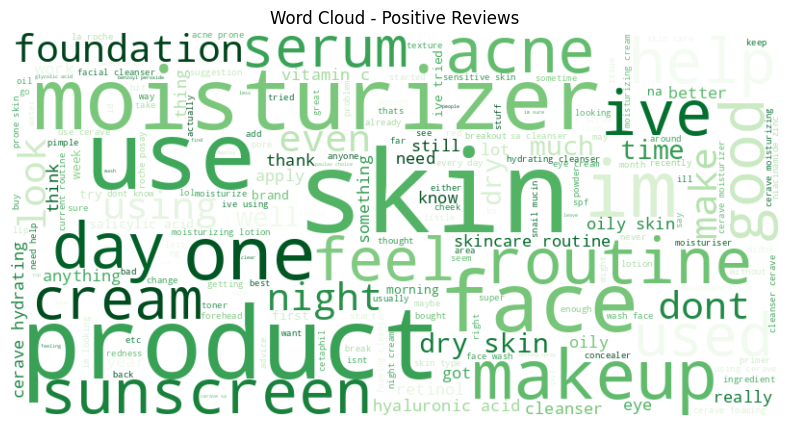

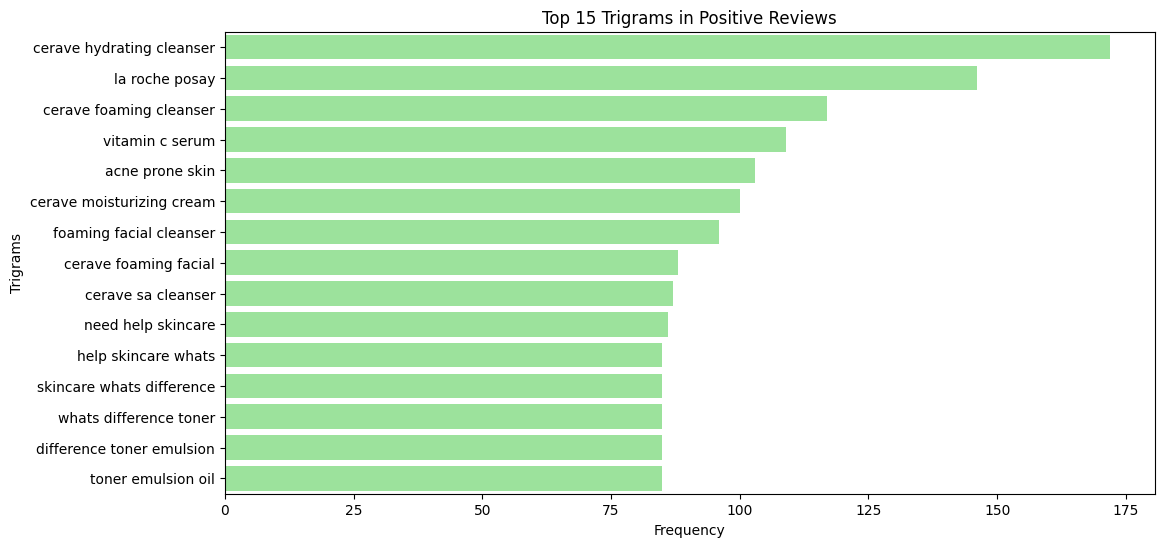

<ipython-input-121-3a327abd0ed1>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews["product_mentions"] = positive_reviews["text"].apply(
<ipython-input-121-3a327abd0ed1>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Greens_r")


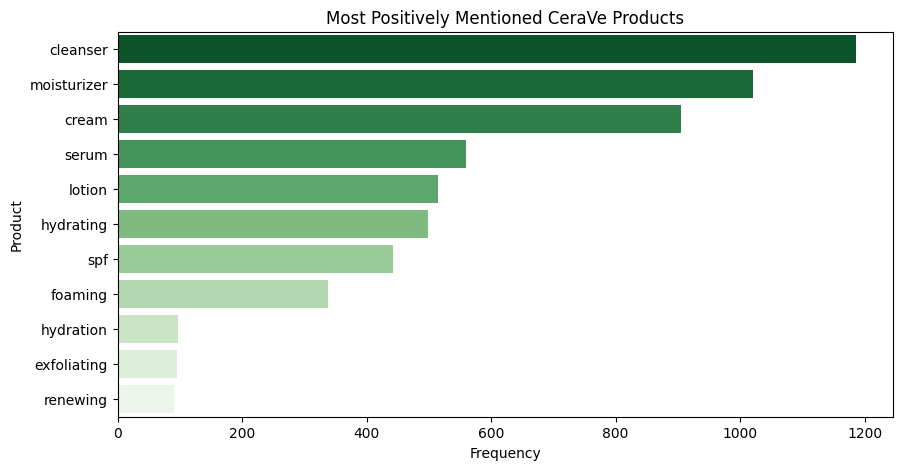

In [ ]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams

# Download required NLTK data
nltk.download("punkt")
nltk.download("stopwords")

# Load dataset
file_path = "data/CeraVe_reddit_with_sentiment.csv"
df = pd.read_csv(file_path)

# Ensure 'text' is a string before applying processing
df["text"] = df["text"].astype(str)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return tokens

# Apply cleaning function
df['tokens'] = df['text'].apply(clean_text)

# Extract positive reviews
positive_reviews = df[df['sentiment_category'] == "Positive"]

# Flatten word lists for trigrams
positive_words = [word for tokens in positive_reviews['tokens'] for word in tokens]

# Generate trigrams
positive_trigrams = list(ngrams(positive_words, 3))

# Find most common trigrams
positive_trigram_freq = Counter(positive_trigrams).most_common(15)

# Convert to DataFrame
df_positive_trigrams = pd.DataFrame(positive_trigram_freq, columns=['Trigram', 'Frequency'])

# Convert trigrams from tuples to readable text
df_positive_trigrams['Trigram'] = df_positive_trigrams['Trigram'].apply(lambda x: ' '.join(x))

# Create word cloud for positive posts
positive_text = " ".join(positive_words)
wordcloud_positive = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_text)

# Display Word Cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()

# Plot Top 15 Trigrams for Positive Reviews
# Ensure sorting by frequency before plotting
df_positive_trigrams = df_positive_trigrams.sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(y=df_positive_trigrams["Trigram"], x=df_positive_trigrams["Frequency"], color="lightgreen")
plt.title("Top 15 Trigrams in Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.show()

### ** Most Common Positively Reviewed CeraVe Products**
# Define key CeraVe product words
cerave_products = ["cleanser", "moisturizer", "hydrating", "foaming", "lotion",
                   "serum", "spf", "cream", "exfoliating", "renewing", "hydration"]

# Count mentions of each product in positive reviews
positive_reviews["product_mentions"] = positive_reviews["text"].apply(
    lambda x: [product for product in cerave_products if product in str(x).lower()]
)
product_counts = Counter([product for sublist in positive_reviews["product_mentions"] for product in sublist])

# Convert to DataFrame and Plot
df_product_mentions = pd.DataFrame(product_counts.items(), columns=["Product", "Frequency"]).sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Greens_r")
plt.title("Most Positively Mentioned CeraVe Products")
plt.xlabel("Frequency")
plt.ylabel("Product")
plt.show()


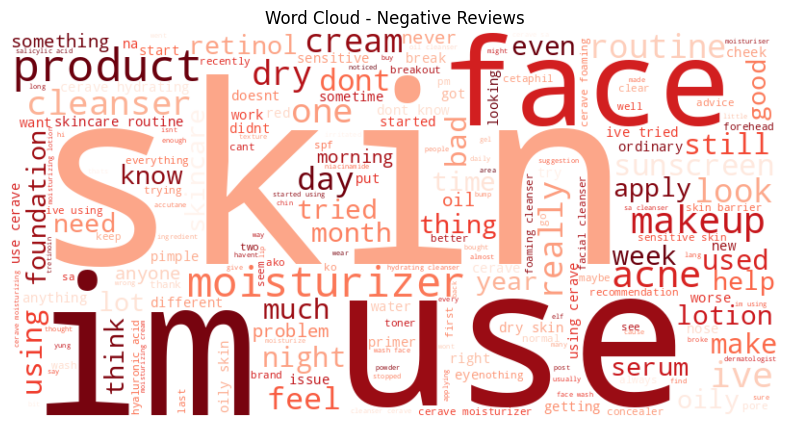

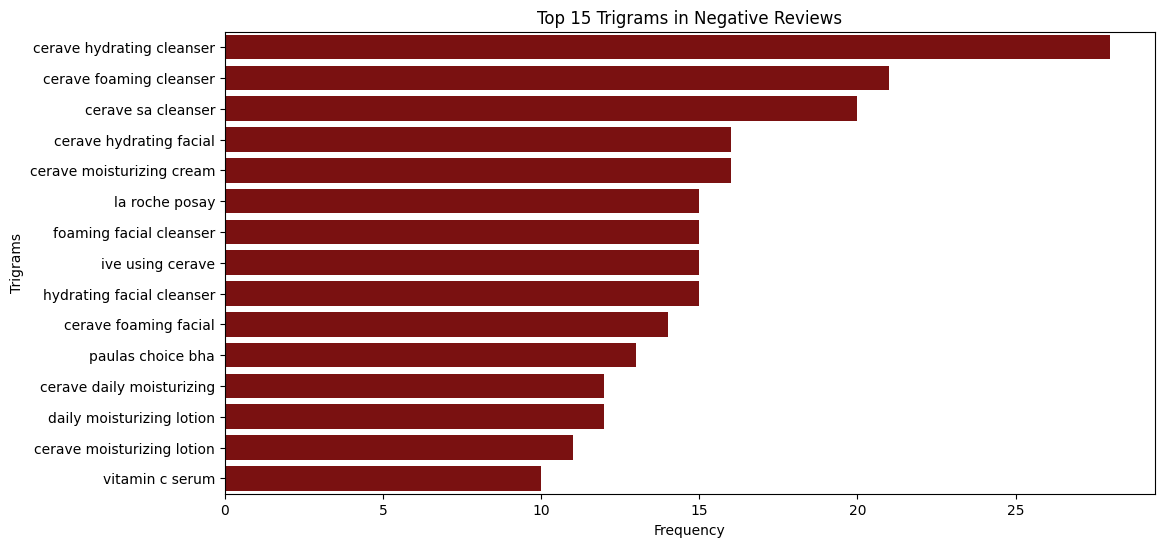

<ipython-input-122-d75f4ec12b5b>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Reds_r")


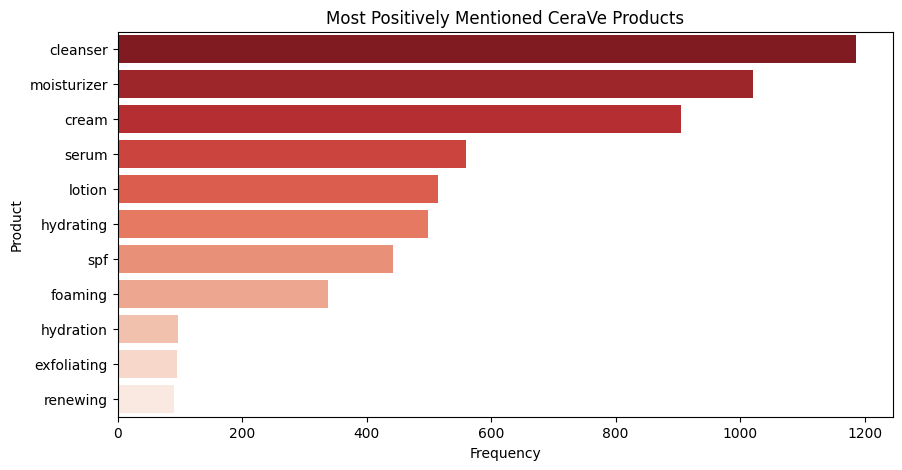

In [ ]:
# Re-run the negative sentiment analysis with the same fixes

# Extract negative reviews
negative_reviews = df[df['sentiment_category'] == "Negative"]

# Flatten word lists for trigrams
negative_words = [word for tokens in negative_reviews['tokens'] for word in tokens]

# Generate trigrams
negative_trigrams = list(ngrams(negative_words, 3))

# Find most common trigrams
negative_trigram_freq = Counter(negative_trigrams).most_common(15)

# Convert to DataFrame
df_negative_trigrams = pd.DataFrame(negative_trigram_freq, columns=['Trigram', 'Frequency'])

# Convert trigrams from tuples to readable text
df_negative_trigrams['Trigram'] = df_negative_trigrams['Trigram'].apply(lambda x: ' '.join(x))

# Create word cloud for negative posts
negative_text = " ".join(negative_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Display Word Cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()

# Plot Top 15 Trigrams for Negative Reviews
df_negative_trigrams = df_negative_trigrams.sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(y=df_negative_trigrams["Trigram"], x=df_negative_trigrams["Frequency"], color='darkred')
plt.title("Top 15 Trigrams in Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(y=df_product_mentions["Product"], x=df_product_mentions["Frequency"], palette="Reds_r")
plt.title("Most Positively Mentioned CeraVe Products")
plt.xlabel("Frequency")
plt.ylabel("Product")
plt.show()
